In [78]:
from keras.models import Sequential,Model
from keras.layers import Input,Conv2D,BatchNormalization,Activation,MaxPooling2D,Flatten,Dense,Dropout,AveragePooling2D 
from keras.datasets import cifar10
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
import imgaug as ia
from imgaug import augmenters as iaa
from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
import cv2
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline

# config = tf.compat.v1.ConfigProto() #allow_soft_placement=True
# config.gpu_options.allow_growth = True #dynamically grow the memory used on the GPU
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
# #session = tf.compat.v1.InteractiveSession(config=config)
# #config.gpu_options.per_process_gpu_memory_fraction = 0.6 # 使用60%的显存
# #config.log_device_placement = True  # to log device placement (on which device the operation ran)


['keras.layers.convolutional'](https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/)

 Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
 
padding='SAME' : output = ceil( input / strides )

padding='Valid' : output = ceil(( input - kernel_size + 1 ) / strides )

### 使用Model

In [5]:
## Same padding、strides=(1,1)
inputs = Input(shape=(13,13,1))
x= Conv2D(filters=32,kernel_size=5,strides=2,padding='same')(inputs)
model = Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13, 13, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          832       
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


### 使用Sequential

In [6]:
input_shape = (32, 32, 3)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))  ##默認strides為(2,2)

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001)) 
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(10, kernel_size=(3, 3), padding='same'))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())


model.add(Dense(28))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

### 简单的神经网络识别手写数字

In [13]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
model = Sequential([Flatten(input_shape=(28, 28)),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    Dense(10, activation='softmax')])
#如果targets是one-hot编码，用categorical_crossentropy
#如果tagets是数字编码，用sparse_categorical_crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20)
model.evaluate(x_test,  y_test)

Epoch 1/20
1875/1875 [==============================] - 1s 642us/step - loss: 0.2856 - accuracy: 0.9167
Epoch 2/20
1875/1875 [==============================] - 1s 606us/step - loss: 0.1348 - accuracy: 0.9599
Epoch 3/20
1875/1875 [==============================] - 1s 635us/step - loss: 0.1029 - accuracy: 0.9692
Epoch 4/20
1875/1875 [==============================] - 1s 657us/step - loss: 0.0847 - accuracy: 0.9742
Epoch 5/20
1875/1875 [==============================] - 1s 608us/step - loss: 0.0730 - accuracy: 0.9774
Epoch 6/20
1875/1875 [==============================] - 1s 601us/step - loss: 0.0636 - accuracy: 0.9793
Epoch 7/20
1875/1875 [==============================] - 1s 605us/step - loss: 0.0571 - accuracy: 0.9818
Epoch 8/20
1875/1875 [==============================] - 1s 611us/step - loss: 0.0514 - accuracy: 0.9830
Epoch 9/20
1875/1875 [==============================] - 1s 604us/step - loss: 0.0466 - accuracy: 0.9852
Epoch 10/20
1875/1875 [==============================] - 1s 595u

[0.08105891942977905, 0.9789000153541565]

### 简单的CNN识别彩色图片类别

In [8]:
# 资料预处理
def normalize(X_train,X_test):
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()    
x_train, x_test = normalize(x_train, x_test) 
one_hot=OneHotEncoder()
y_train=one_hot.fit_transform(y_train).toarray()
y_test=one_hot.transform(y_test).toarray()
# 建立CNN模型
classifier=Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(32,32,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Conv2D(32,(3,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(activation='relu',units=100,kernel_regularizer=regularizers.l2(l=0.001)))
classifier.add(BatchNormalization()) 
classifier.add(Dropout(rate=0.5))
classifier.add(Dense(activation='relu',units=50,kernel_regularizer=regularizers.l2(0.001)))
classifier.add(BatchNormalization()) ##BatchNormalization
classifier.add(Dropout(rate=0.3))##Dropout
classifier.add(Dense(activation='softmax',units=10))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [9]:
img_gen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=10,width_shift_range=0.1,
                            height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=False,dtype=np.float32)
img_gen.fit(x_train)
earlystop = EarlyStopping(monitor='val_loss', patience=8)
classifier.fit(img_gen.flow(x_train, y_train, batch_size=32) ,steps_per_epoch=20,
                               epochs=20, validation_data = (x_test, y_test),callbacks = [earlystop])

Epoch 1/20
20/20 [==============================] - 1s 73ms/step - loss: 3.1447 - accuracy: 0.1453 - val_loss: 2.5229 - val_accuracy: 0.1710
Epoch 2/20
20/20 [==============================] - 1s 67ms/step - loss: 2.8406 - accuracy: 0.1953 - val_loss: 2.3902 - val_accuracy: 0.2445
Epoch 3/20
20/20 [==============================] - 1s 67ms/step - loss: 2.6449 - accuracy: 0.2188 - val_loss: 2.3154 - val_accuracy: 0.2550
Epoch 4/20
20/20 [==============================] - 1s 66ms/step - loss: 2.6122 - accuracy: 0.2250 - val_loss: 2.3007 - val_accuracy: 0.2538
Epoch 5/20
20/20 [==============================] - 1s 67ms/step - loss: 2.4935 - accuracy: 0.2531 - val_loss: 2.3012 - val_accuracy: 0.2513
Epoch 6/20
20/20 [==============================] - 1s 67ms/step - loss: 2.4133 - accuracy: 0.2594 - val_loss: 2.3425 - val_accuracy: 0.2433
Epoch 7/20
20/20 [==============================] - 1s 66ms/step - loss: 2.4083 - accuracy: 0.2453 - val_loss: 2.3483 - val_accuracy: 0.2416
Epoch 8/20
20

### 认识ImageDataGenerator

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


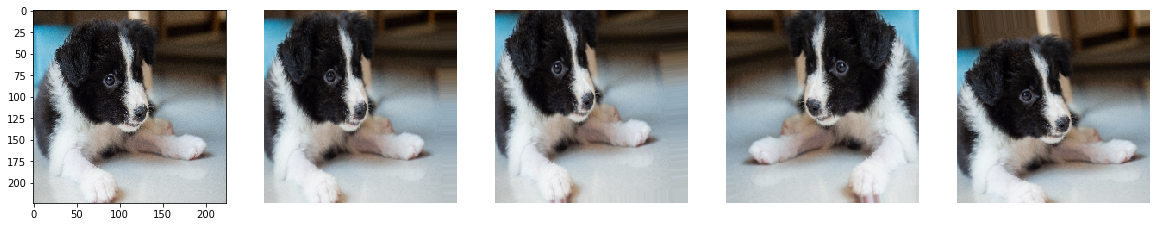

In [12]:
img_gen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                              rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,
                              shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=False,dtype=np.float32)
width=224
height=224
batch_size=4
img = cv2.imread('data/Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img_combine=np.array([img,img,img,img],dtype=np.uint8) ##輸入generator要是四維，(224,224,3)變成(4,224,224,3)
#img_gen.fit(img_combine)
batch_gen = img_gen.flow(img_combine, batch_size=4)
assert next(batch_gen).shape==(batch_size, width, height, 3)
plt.figure(figsize=(20,10))
i = 1
for batch in batch_gen:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin) ##原圖
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0, :, :, :].astype(np.uint8))
    plt.imshow(batch[1, :, :, :].astype(np.uint8))
    plt.imshow(batch[2, :, :, :].astype(np.uint8))
    plt.imshow(batch[3, :, :, :].astype(np.uint8))
    plt.axis('off')
    i += 1
    if i > 4:
        break  # or the generator would loop infinitely

In [46]:
#Training Generator
train_datagen = ImageDataGenerator(rescale = 2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
#Test Generator，只需要Rescale，不需要其他增強
test_datagen = ImageDataGenerator(rescale = 1./255)
#將路徑給Generator，自動產生Label
training_set = train_datagen.flow_from_directory('D:/DL_CV/dataset/sampletrain',
                                                 target_size = (32, 32),
                                                 batch_size = 8,
                                                 class_mode='binary')
test_set = test_datagen.flow_from_directory('D:/DL_CV/dataset/sampletest',
                                            target_size = (32, 32),
                                            batch_size = 8,
                                            class_mode='binary')
classifier=Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(32,32,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Conv2D(32,(3,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(activation='relu',units=100,kernel_regularizer=regularizers.l2(l=0.001))) ##regularizers
classifier.add(BatchNormalization()) 
classifier.add(Dropout(rate=0.5)) 
classifier.add(Dense(activation='relu',units=100,kernel_regularizer=regularizers.l2(0.001)))##regularizers
classifier.add(BatchNormalization()) 
classifier.add(Dropout(rate=0.3))
classifier.add(Dense(activation='softmax',units=1))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit_generator(training_set,steps_per_epoch = 20,epochs = 20,
                         validation_data = training_set,validation_steps = 20)

Found 200 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Epoch 1/20
20/20 [==============================] - 1s 38ms/step - loss: 7.6432 - accuracy: 0.5125 - val_loss: 7.3839 - val_accuracy: 0.5250
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 7.6314 - accuracy: 0.5063 - val_loss: 7.5986 - val_accuracy: 0.5063
Epoch 3/20
20/20 [==============================] - 1s 33ms/step - loss: 7.4860 - accuracy: 0.5125 - val_loss: 7.9479 - val_accuracy: 0.4812
Epoch 4/20
20/20 [==============================] - 1s 33ms/step - loss: 7.1774 - accuracy: 0.5312 - val_loss: 7.6468 - val_accuracy: 0.5000
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 7.6425 - accuracy: 0.5000 - val_loss: 8.0197 - val_accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 1s 32ms/step - loss: 6.8734 - accuracy: 0.5500 - val_loss: 7.8240 - val_accuracy: 0.4875
Epoch 7/20
20/20 [==============================] - 1s 32ms/step - loss: 7

In [64]:
#預測新照片
test_image = image_utils.load_img('D:/DL_CV/dataset/sampletest/10.jpg', target_size=(32, 32)) # 下载图片
test_image = image_utils.img_to_array(test_image) # 将图片变成(32,32,3)矩形
test_image = np.expand_dims(test_image, axis=0) # (1,32,32,3)
classifier.predict_on_batch(test_image)

array([[1.]], dtype=float32)

### 认识imgaug.augmenters

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


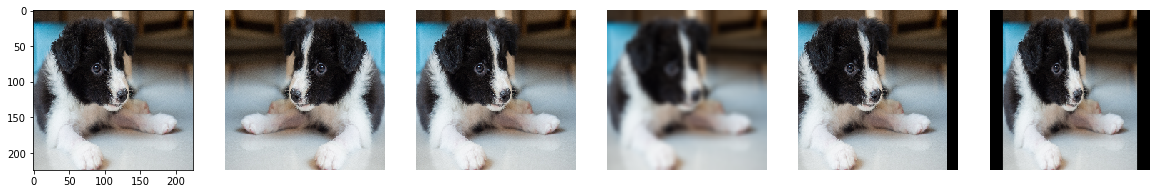

In [81]:
img = cv2.imread('data/Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32)

images = np.random.randint(0, 255, (5, 224, 224, 3), dtype=np.uint8)##創造一個array size==(5, 224, 224, 3)

flipper = iaa.Fliplr(1.0) #水平翻轉機率==1.0
images[0] = flipper.augment_image(img) 

vflipper = iaa.Flipud(0.4) #垂直翻轉機率40%
images[1] = vflipper.augment_image(img) 

blurer = iaa.GaussianBlur(3.0)
images[2] = blurer.augment_image(img) # 高斯模糊圖像( sigma of 3.0)

translater = iaa.Affine(translate_px={"x": -16}) #向左橫移16個像素
images[3] = translater.augment_image(img) 

scaler = iaa.Affine(scale={"x": (0.8, 1.2)}) # 縮放照片，區間(0.8-1.2倍)
images[4] = scaler.augment_image(img)

i=1
plt.figure(figsize=(20,20))
for image in images:
    plt.subplot(1, 6, 1)
    plt.imshow(img_origin.astype(np.uint8))
    plt.subplot(1, 6, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

### 包裝自定義Augmentation 與 Imgaug Augmentation

In [84]:
from PIL import Image

import os
import pickle
import numpy as np
import cv2
import glob
import pandas as pd
import time
import random
import imgaug as ia
import imgaug.augmenters as iaa

'''隨機改變亮度'''    
class RandomBrightness(object):
    '''Function to randomly make image brighter or darker
    Parameters
    ----------
    delta: float
        the bound of random.uniform distribution
    '''
    def __init__(self, delta=16):
        assert 0 <= delta <= 255
        self.delta = delta

    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''隨機改變對比'''
class RandomContrast(object):
    '''Function to strengthen or weaken the contrast in each image
    Parameters
    ----------
    lower: float
        lower bound of random.uniform distribution
    upper: float
        upper bound of random.uniform distribution
    '''
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "contrast upper must be >= lower."
        assert lower >= 0, "contrast lower must be non-negative."
        self.lower = lower
        self.upper = upper

    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''包裝所有Augmentation'''
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image= t(image)
        return image

'''包裝Imgaug'''
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image):
        image = self.sequence.augment_image(image)
      
        return image
    
class TrainAugmentations(object):
    def __init__(self):
        #Define imgaug.augmenters Sequential transforms
        sometimes = lambda aug: iaa.Sometimes(0.4, aug) # applies the given augmenter in 50% of all cases

        img_seq = iaa.Sequential([
             sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5)),
             sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=1),),
             sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
             sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
            ],random_order=True)
        
        self.aug_pipeline = Compose([
            RandomBrightness(16), #make image brighter or darker
            RandomContrast(0.9, 1.1), #strengthen or weaken the contrast in each image
            ImgAugSequence(img_seq),
        ])
        

    def __call__(self, image):
        image= self.aug_pipeline(image)
        return image
    
Augmenation=TrainAugmentations()

D:\Anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


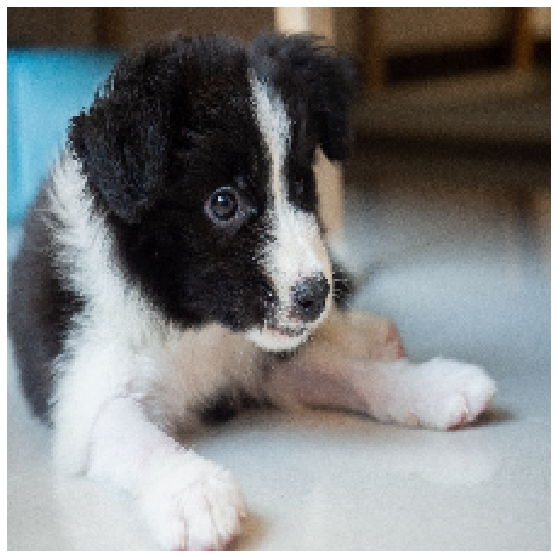

In [88]:
##輸入照片
img = cv2.imread('data\Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB

output=Augmenation(img) 

##畫出來
plt.figure(figsize=(10,10))
for image in images_aug:
    plt.imshow(output.astype(np.uint8))
    plt.axis('off')


### 鎖住隨機性-主要用在Semantic segmentation中

In [89]:
class MaskAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() ##用來關閉隨機性
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image,  mask= image.astype(np.float32), mask.astype(np.float32)
        return image,  mask